In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda, Input, Dense, Layer, Concatenate
from tensorflow.keras.models import Model
import random as rn
import numpy as np
import tensorflow as tf

rn.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim), seed=123)
    
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# image_size = x_train.shape[1]
# original_dim = image_size * image_size
# x_train = np.reshape(x_train, [-1, original_dim])
# x_test = np.reshape(x_test, [-1, original_dim])
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255

# input_shape = (original_dim, )
# intermediate_dim = 512
# batch_size = 128
# latent_dim = 2
# epochs = 50

# y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

# NUM_CLASSES = y_train_one_hot.shape[1]

In [2]:
data = np.load('./data/ampli_data.npz')

In [3]:
relations = data['relations']
entities = data['entities']

entity_embeddings = data['entity_embeddings']
relation_embeddings = data['relation_embeddings']

X = data['X']

relation_dict = dict(zip(relations, relation_embeddings))
entity_dict = dict(zip(entities, entity_embeddings))

embedding_dim = entity_embeddings.shape[1]
original_dim = embedding_dim

In [4]:
intermediate_dim = 64
batch_size = 1
latent_dim = 2
epochs = 50

In [5]:
# X_embedding = []

# for i in X:
    
#     head, rel, tail = i
    
#     head_embed = entity_dict[head]
#     tail_embed = entity_dict[tail]
#     rel_embed = relation_dict[rel]
    
#     X_embedding.append([head_embed, rel_embed, tail_embed])

# X_embedding = np.array(X_embedding)

# train_dataset = tf.data.Dataset.from_tensor_slices(X_embedding).batch(batch_size)

# for i in train_dataset:
    
#     print(i)

In [6]:
head_embedding = []
rel_embedding = []
tail_embedding = []

for i in X:
    
    head, rel, tail = i
    
    head_embed = entity_dict[head]
    tail_embed = entity_dict[tail]
    rel_embed = relation_dict[rel]  
    
    head_embedding.append(head_embed)
    rel_embedding.append(rel_embed)
    tail_embedding.append(tail_embed)
    
head_embedding = np.array(head_embedding)
rel_embedding = np.array(rel_embedding)
tail_embedding = np.array(tail_embedding)

In [7]:
# X_input = Input(shape=(x_train.shape[1],)) 
# cond = Input(shape=(NUM_CLASSES,))
# inputs = Concatenate()([X_input, cond])

head_input = Input(shape=(embedding_dim,))
rel_input = Input(shape=(embedding_dim))
tail_input = Input(shape=(embedding_dim,))

inputs = Concatenate()([head_input, rel_input, tail_input])

encoder_h = Dense(intermediate_dim, activation='relu',name='encoder_h')(inputs)
mu = Dense(latent_dim, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(latent_dim, activation='linear', name='l_sigma')(encoder_h)

z = Lambda(sampling, output_shape = (latent_dim, ))([mu, l_sigma])

zc = Concatenate(name='z_condition')([z, head_input, rel_input, tail_input])
#zc = Concatenate(name='z_condition')([z, rel_input, tail_input])

decoder_hidden = Dense(intermediate_dim, activation='relu', name='decoder_hidden')
decoder_output = Dense(original_dim, activation='sigmoid', name='decoder_output')

decoder_intermediate = decoder_hidden(zc)
decoder_output_layer = decoder_output(decoder_intermediate)

cvae = Model([head_input, rel_input, tail_input],
             [decoder_output_layer,mu, l_sigma])
encoder = Model(inputs=cvae.inputs, outputs=[cvae.get_layer('mu').output, 
                 cvae.get_layer('l_sigma').output])

# decoder_z = Input(shape=(latent_dim,))
# decoder_cond = Input(shape=(NUM_CLASSES,))
# decoder_input = Concatenate()([decoder_z, decoder_cond])

decoder_z = Input(shape=(latent_dim,))
decoder_head = Input(shape=(embedding_dim))
decoder_rel = Input(shape=(embedding_dim))
decoder_tail = Input(shape=(embedding_dim))

decoder_input = Concatenate()([decoder_z, decoder_head, decoder_rel, decoder_tail])

slice_decoder_hidden = decoder_hidden(decoder_input)
slice_decoder_output = decoder_output(slice_decoder_hidden)
decoder = Model([decoder_z, decoder_head, decoder_rel, decoder_tail], slice_decoder_output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (head_embedding,rel_embedding, tail_embedding)).batch(batch_size)

for epoch in range(epochs):
    
    loss_metric = tf.keras.metrics.Mean()
    
    #for x_batch_train, y_batch_train in train_dataset:
    for head, rel, tail in train_dataset:
        
        with tf.GradientTape() as tape:
            
            reconstructed, z_mu, z_sigma = cvae((head, rel, tail))
            
            mse_loss = mse_loss_fn(head, reconstructed)
            mse_loss *= original_dim

            kl_loss = -0.5 * tf.reduce_sum(1 + z_sigma - tf.square(z_mu) - tf.exp(z_sigma), axis=-1)
            
            loss = tf.reduce_mean(mse_loss + kl_loss)

        grads = tape.gradient(loss, cvae.trainable_weights)
        optimizer.apply_gradients(zip(grads, cvae.trainable_weights))

        loss_metric(loss)

    if not epoch % 10:
        
        print('Epoch %s: mean loss = %s' % (epoch, loss_metric.result()))

Epoch 0: mean loss = tf.Tensor(3.4553413, shape=(), dtype=float32)
Epoch 10: mean loss = tf.Tensor(1.2877439, shape=(), dtype=float32)
Epoch 20: mean loss = tf.Tensor(0.731456, shape=(), dtype=float32)
Epoch 30: mean loss = tf.Tensor(0.6320995, shape=(), dtype=float32)
Epoch 40: mean loss = tf.Tensor(0.56671613, shape=(), dtype=float32)


In [8]:
#z_mean_test = encoder((x_test, y_test_one_hot))
#z_mean_test, z_sigma_test = encoder((head_embedding,rel_embedding, tail_embedding))
z_mean_test, z_sigma_test = encoder((head_embedding,rel_embedding, tail_embedding,
                                    head_embedding,rel_embedding, tail_embedding))
#z_mean_test = encoder((head_embedding,rel_embedding, tail_embedding))

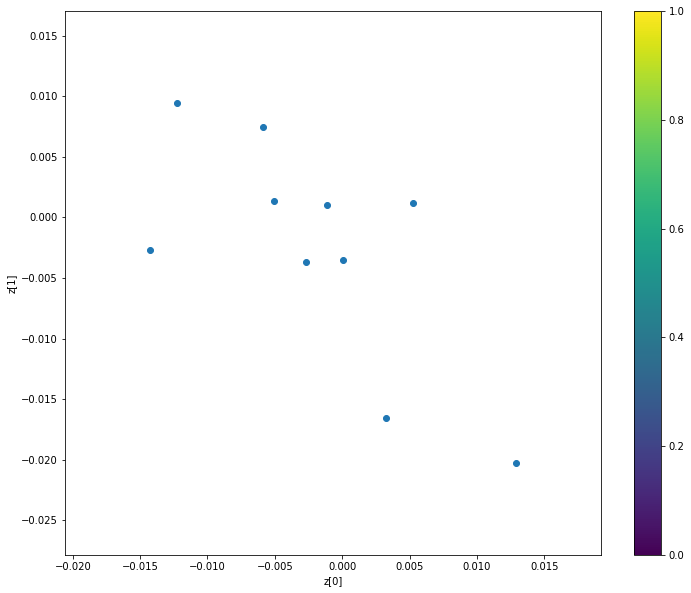

In [9]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean_test[:, 0], z_mean_test[:, 1])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [10]:
# z_sample = np.random.rand(1,latent_dim)

# new = decoder.predict([z_sample, head_embedding[0:1,],rel_embedding[0:1] ,tail_embedding[0:1]])
# full = np.concatenate((head_embedding, rel_embedding, tail_embedding), axis=1)

# print(X[0])

# XX = np.sum(np.square(new), axis=1)[:,np.newaxis]
# YY = np.sum(np.square(entity_embeddings), axis=1)

# dist = XX + YY - 2 * np.dot(new,entity_embeddings.T)

# entities[np.argmin(dist)]

# YY = np.sum(np.square(full), axis=1)
# dist = XX + YY - 2 * np.dot(new,full.T)

# np.argmin(dist)

In [11]:
# print('XX',XX.shape)
# print('YY',YY.shape)
# print('new',new.shape)
# print('entity embedding',entity_embeddings.shape)
# print('dot', np.dot(new,entity_embeddings.T).shape)

# print('\n')
# print('XX',XX.shape)
# print('YY',np.sum(np.square(full), axis=1).shape)
# print('new',new.shape)
# print('entity_embedding',full.shape)
# print('dot',np.dot(new,full.T).shape)

In [19]:
base_h, base_r, base_t = X[0]

base_head_embed = entity_dict[base_h].reshape(1,-1)
base_tail_embed = entity_dict[base_t].reshape(1,-1)
base_rel_embed = relation_dict[base_r].reshape(1,-1)

means, stds = encoder([head_embedding[0:1],rel_embedding[0:1],tail_embedding[0:1]])
#means = new_encoder([head_embedding[0].reshape(1,-1),rel_embedding[0].reshape(1,-1),
#                       tail_embedding[0].reshape(1,-1)])
a = np.random.multivariate_normal(means.numpy().flatten(), 
                                      np.diag(np.exp(.5 * stds.numpy().flatten())), size=1000)
kld = tf.keras.losses.KLDivergence()
scores = []

for i in X:
    
    head, rel, tail = i
    
    head_embed = entity_dict[head].reshape(1,-1)
    tail_embed = entity_dict[tail].reshape(1,-1)
    rel_embed = relation_dict[rel].reshape(1,-1)
    
    new_means, new_stds = encoder([base_head_embed,base_rel_embed,base_tail_embed])
    #new_means = new_encoder([head_embed,rel_embed,tail_embed])

    b = np.random.multivariate_normal(new_means.numpy().flatten(), np.diag(np.exp(.5 * new_stds.numpy().flatten())),size=1000)
    
    triple = [head, rel, tail]
    
    #score = kld(a,b).numpy()
    score = kld(new_means.numpy(), means.numpy()).numpy()
    
    scores.append((triple, score))

In [20]:
print(X[0])
sorted(scores, key=lambda tup: tup[1])

['George' 'worksFor' 'Acme Inc']


[(['George', 'worksFor', 'Acme Inc'], 0.0),
 (['George', 'isA', 'Person'], 0.0),
 (['Mike', 'worksFor', 'Acme Inc'], 0.0),
 (['Mike', 'friendWith', 'George'], 0.0),
 (['Mike', 'isA', 'Person'], 0.0),
 (['Mike', 'bornIn', 'Liverpool'], 0.0),
 (['Mike', 'likes', 'Liverpool FC'], 0.0),
 (['Liverpool FC', 'basedIn', 'Liverpool'], 0.0),
 (['Liverpool FC', 'isA', 'FootballTeam'], 0.0),
 (['Liverpool', 'isA', 'City'], 0.0)]

In [14]:
#new_encoder = Model(inputs=cvae.inputs, outputs=[cvae.get_layer('lambda').output])
#new_encoder((head_embedding[[0,0]],rel_embedding[[0,0]],tail_embedding[[0,0]]))
# a = np.random.multivariate_normal(means.numpy().flatten(), 
#                                      np.diag(np.exp(.5 * stds.numpy().flatten())), size=100)

In [15]:
#encoder((head_embedding[[0,0]],rel_embedding[[0,0]],tail_embedding[[0,0]]))

In [16]:
# digit_size = 28

# z_sample = np.random.rand(1, 2)

# plt.figure(figsize=(20, 2))

# for i in range(10):
    
#     c = tf.keras.utils.to_categorical(i,NUM_CLASSES)
    
#     c = c.reshape(1,-1)
#     x_decoded = decoder.predict([z_sample, c])
#     digit = x_decoded[0].reshape(digit_size, digit_size)

#     plt.subplot(1, NUM_CLASSES, i+1)
#     plt.axis('off')
#     plt.imshow(digit, cmap='Greys_r')
# plt.show()